In [1]:
%load_ext autoreload
%load_ext line_profiler

In [2]:
import sys
sys.path.append('../../') #takes us to the directory named foreground_functions that housed the foreground_function.py 
#and the w3j.npy files

#------packages-------------------
%pylab inline
import time
import healpy as hp
import matplotlib.pyplot as plt
import foreground_functions as ff
from scipy.optimize import curve_fit, minimize
import emcee
import corner

Populating the interactive namespace from numpy and matplotlib


# Foreground parameters

In [3]:
#the parameters chosen here (except gamma) are from the BICEP 2018 paper. The alphas differ by addition of 2, as we've
#calculated the C_ells, while the BICEP paper models the D_ells. The amplitudes also have had to be scaled to pivot
#frequency of 95 GHz so differ by a factor (95/original pivot)^beta
A_s_BICEP = 1.0 #micro K^2
A_d_BICEP = 4.6 #micro K^2
alpha_s_BICEP = -0.6
alpha_d_BICEP = -0.4


alpha_s = alpha_s_BICEP - 2 #convert from D_ells to C_ells (ish)
beta_s = -3.1
gamma_s = 0 #-2.6 is the SO value for this
A_s = A_s_BICEP * (ff.scale_synch(95e9, beta_s)/ff.scale_synch(23e9, beta_s))**2 * 2*pi/(80*81) # scale to new frequency and convert from D_ells to C_ells
A_s = A_s[0] #make it stop being an array

alpha_d = alpha_s_BICEP - 2 #convert from D_ells to C_ells (ish)
beta_d = 1.6
gamma_d = 0 #-3.5
A_d = A_d_BICEP * (ff.scale_synch(95e9, beta_d)/ff.scale_synch(353e9, beta_d))**2 * 2*pi/(80*81) # scale to new frequency and convert from D_ells to C_ells
A_d = A_d[0] #make it stop being an array



params_s = [A_s, alpha_s, beta_s, gamma_s]
params_d = [A_d, alpha_d, beta_d, gamma_d] 
params_fg = params_s + params_d

nside=128
ells = np.arange(384)
freqs = np.linspace(30,300,10)*1.e9 
freqs_SO = np.array([27, 39, 93, 145, 225, 280])*1e9

# CMB data

In [4]:
#the D_ells of the CMB with r=0.01
camb_lens_r1 = loadtxt('../../power_spectra/camb_lens_r1.dat').T
camb_lens_nobb = loadtxt('../../power_spectra/camb_lens_nobb.dat').T
primo_bb = camb_lens_r1[3]
lens_bb = camb_lens_nobb[3]
r = 0.01
bb_001 = (r * primo_bb + lens_bb)[:384]

In [5]:
def cmb(ells, r):
    return r*primo_bb[:len(ells)] + lens_bb[:len(ells)]

In [6]:
def cosmic_var(model):
    var = np.zeros((len(freqs),len(ells)))
    cosmic_var = 2/(2*ells + 1) * model**2
    return cosmic_var

# define the input model for reference and the associated cosmic variance (do this for my freqs first then we can try with SO stuff)

In [37]:
input_model = ff.auto0x0_fg(ells, freqs, params_fg) + cmb(ells, 0.01)
input_cosmic_var = cosmic_var(input_model)

In [38]:
def chi2_cmb(params, ells, freqs, cosmic_var, data):
    A_s, alpha_s, beta_s, A_d, alpha_d, beta_d, r = params
    long_params = [A_s, alpha_s, beta_s, 0.0, A_d, alpha_d, beta_d, 0.0]

    chi2=0
    model_made = ff.auto0x0_fg(ells, freqs, long_params) + cmb(ells, r)
    
    chi2 = (data[:,30:] - model_made[:,30:])**2 / cosmic_var[:,30:]
    return np.sum(chi2)

# data to be fit

In [39]:
data = ff.const_ps_data_fg(ells, freqs, params_fg) + cmb(ells, 0.01)

# minimise to initialise the MCMC

In [40]:
initial_cmb = [1.e-5, -3., -2.5, 1.e-9, -3., 2., 1.e-1]

In [41]:
soln = minimize(chi2_cmb, initial_cmb, args=(ells, freqs, input_cosmic_var, data), method='Powell')
print(soln)

   direc: array([[ 1.20966466e-08, -7.47143766e-03,  2.48998523e-02,
         7.39300107e-09,  8.41865504e-03, -1.17694261e-02,
        -5.00069927e-04],
       [ 1.79070930e-08, -1.55952167e-02,  3.22429108e-02,
         5.31245594e-09, -4.78815727e-03, -6.36990824e-04,
        -8.50374814e-04],
       [ 1.44141651e-08,  2.75054874e-02,  4.41596779e-02,
         4.36637342e-08, -1.12460128e-02, -3.14076239e-02,
        -1.97620654e-03],
       [-1.56884163e-08, -7.81739472e-02, -1.00815496e-01,
         9.40485709e-09,  1.32601043e-02, -1.94435507e-02,
         2.17410827e-04],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00],
       [ 2.87744934e-09,  2.23611935e-03,  5.90414056e-03,
        -5.94699692e-10, -9.62114180e-04,  1.05018745e-03,
        

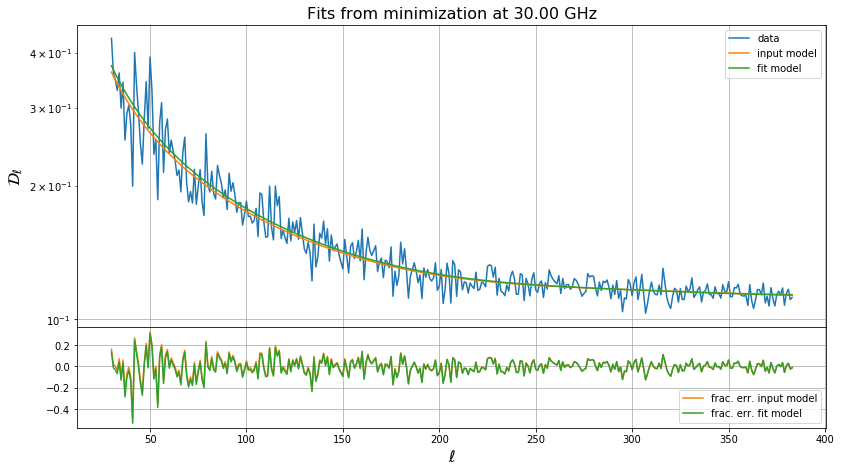

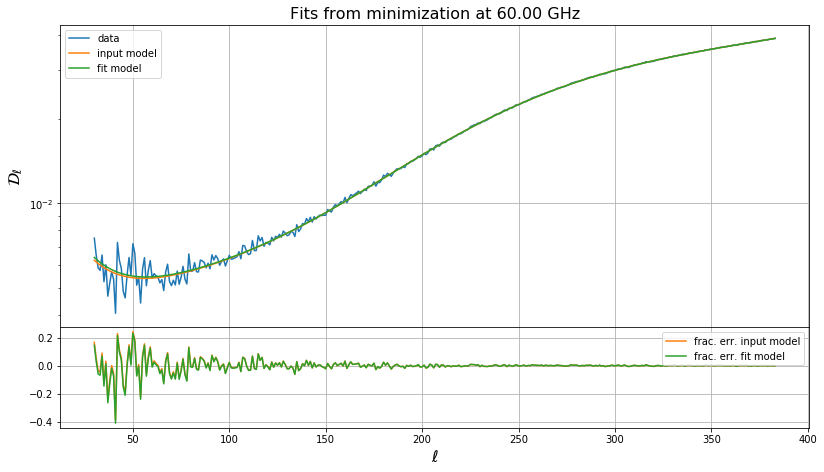

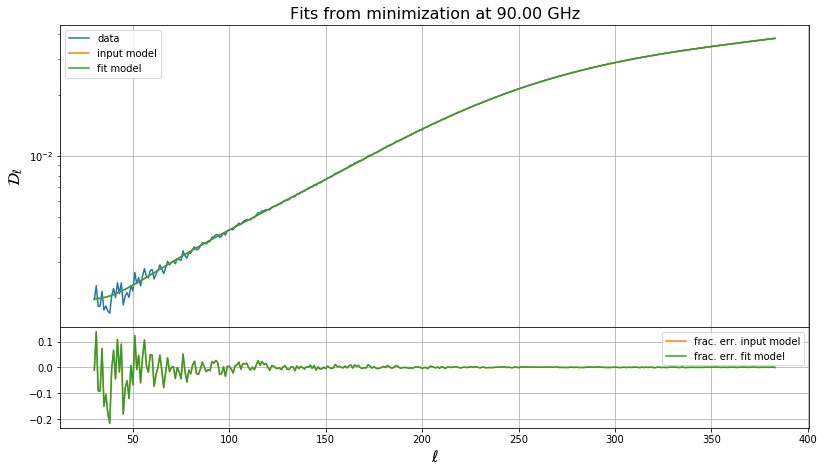

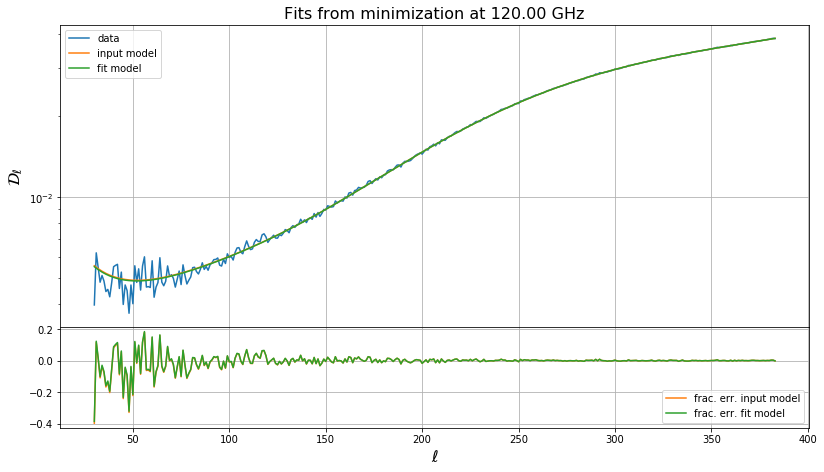

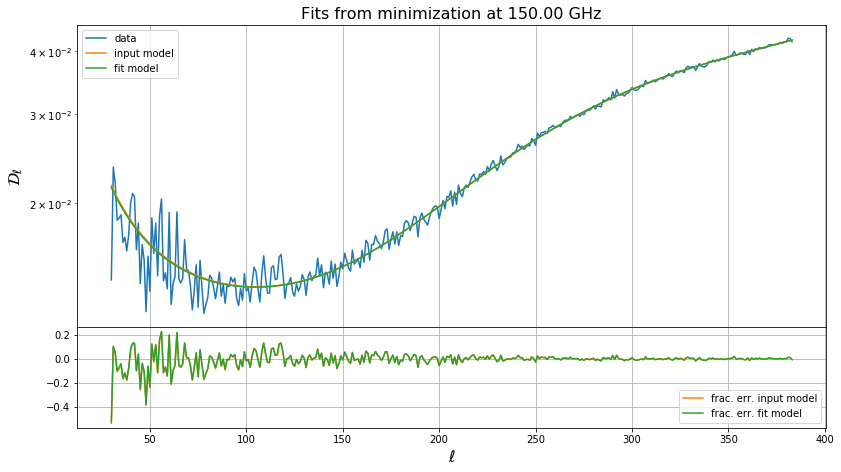

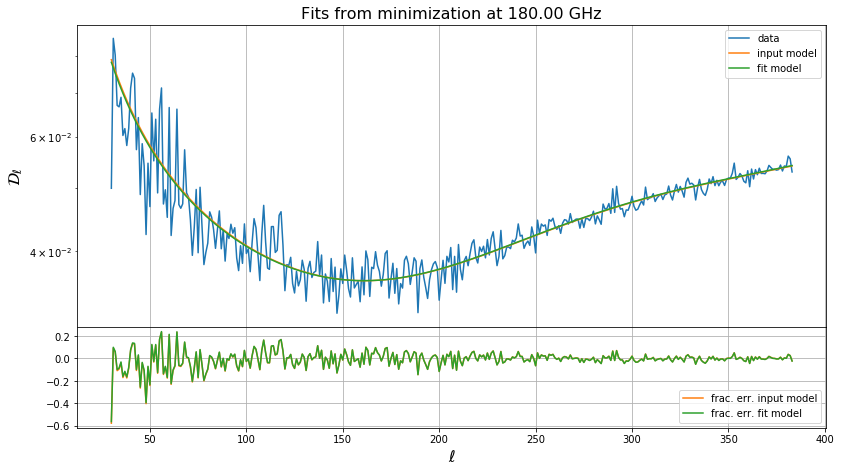

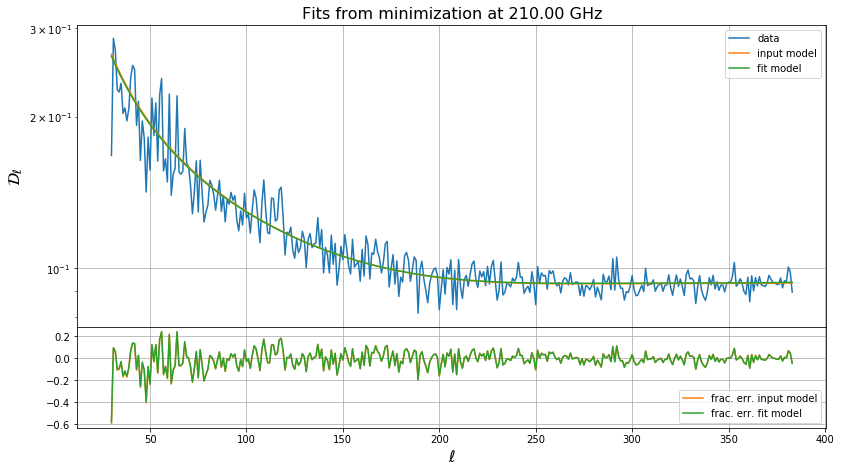

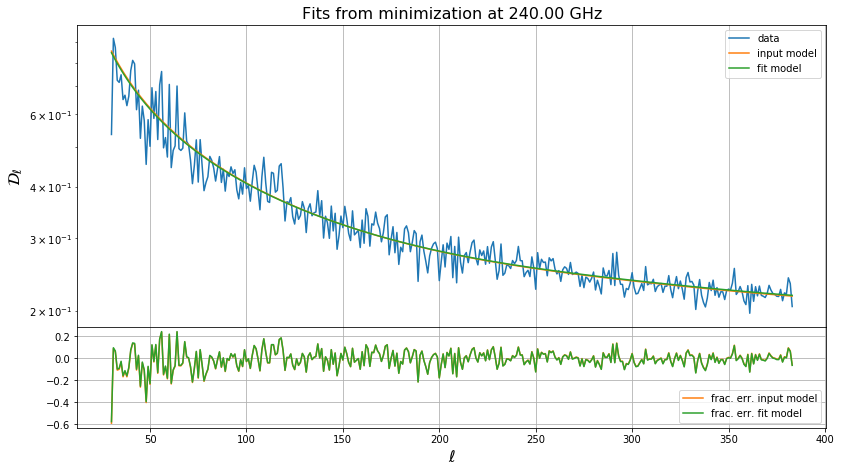

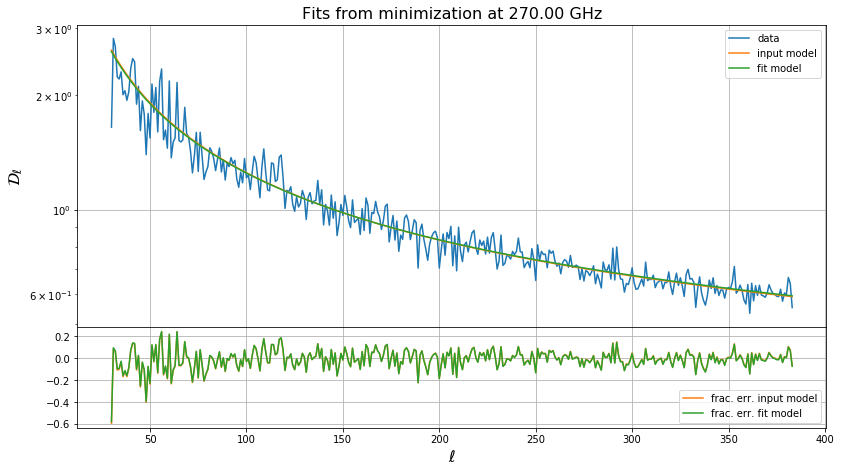

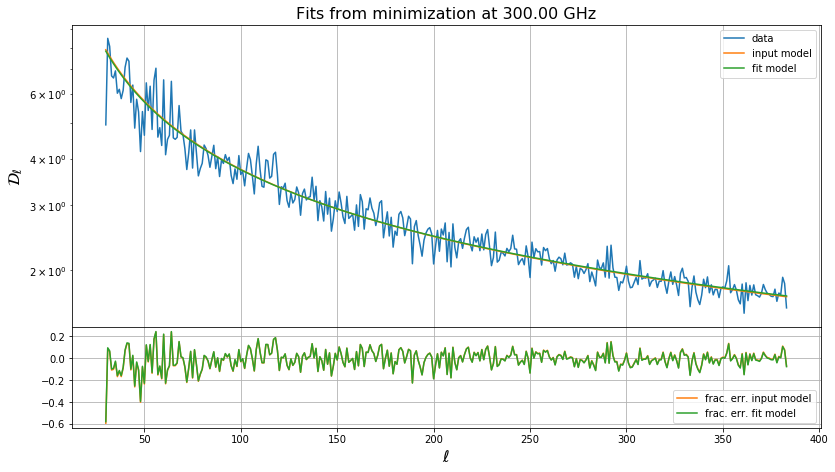

In [42]:
# check the fit and the input against the data
input_model = ff.auto0x0_fg(ells, freqs, params_fg) + cmb(ells, 0.01)
x = soln.x
fit = ff.auto0x0_fg(ells, freqs, [x[0], x[1], x[2], 0, x[3], x[4], x[5], 0]) + cmb(ells, x[-1])

for i in range(len(freqs)):
    fig1 = figure(figsize=(13,7))
    frame1=fig1.add_axes((.1,.3,.8,.6))
    frame1.set_xticklabels([]) #Remove x-tic labels for the first frame
    semilogy(ells[30:], data[i][30:], label='data')
    semilogy(ells[30:], input_model[i][30:], label='input model', color='C1')
    semilogy(ells[30:], fit[i][30:], label='fit model', color='C2')
    grid()
    title('Fits from minimization at {:.2f} GHz'.format(freqs[i]/1e9), fontsize=16)
    ylabel(r'$\mathcal{D}_\ell$', fontsize=16)
    legend()
    
    
    frame2=fig1.add_axes((.1,.1,.8,.2)) 
    plot(ells[30:], (data[i][30:]-input_model[i][30:])/data[i][30:], color='C1', label='frac. err. input model')
    plot(ells[30:], (data[i][30:]-fit[i][30:])/data[i][30:], color='C2', label='frac. err. fit model')
    xlabel(r'$\ell$', fontsize=16)
    legend()
    grid()

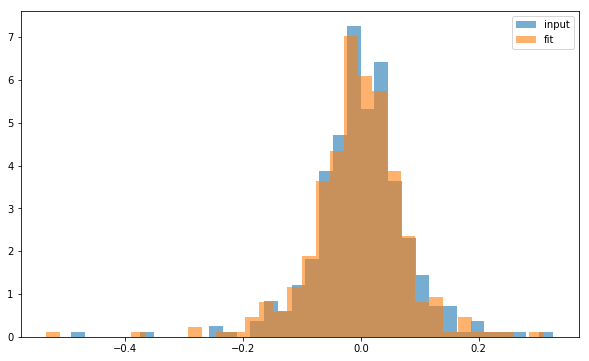

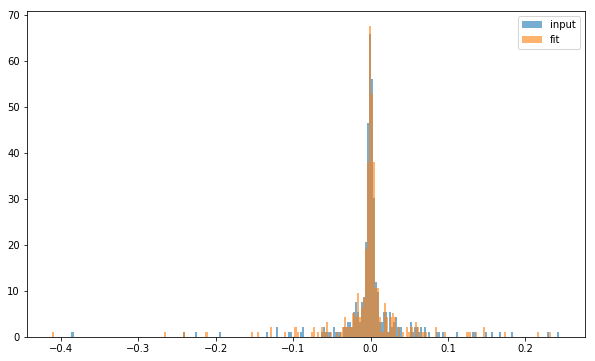

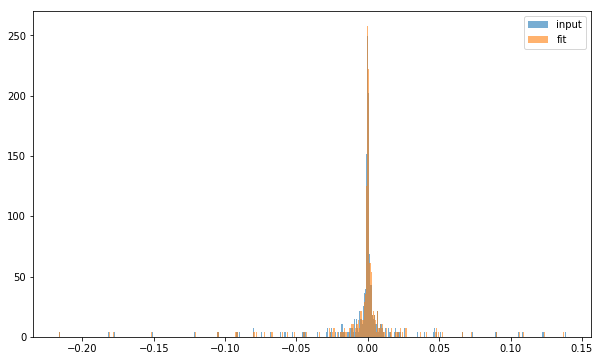

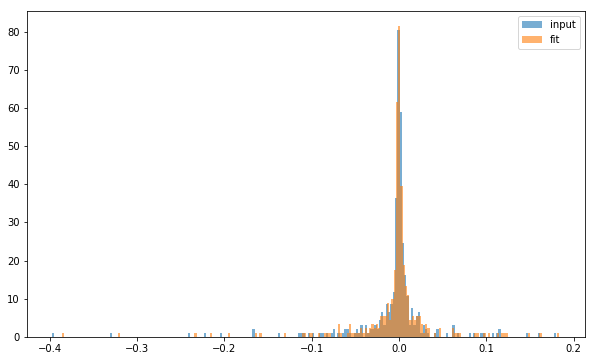

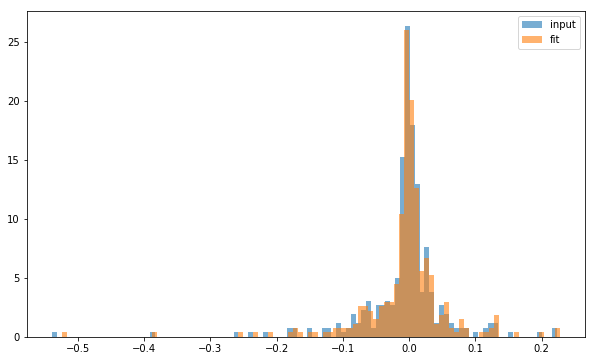

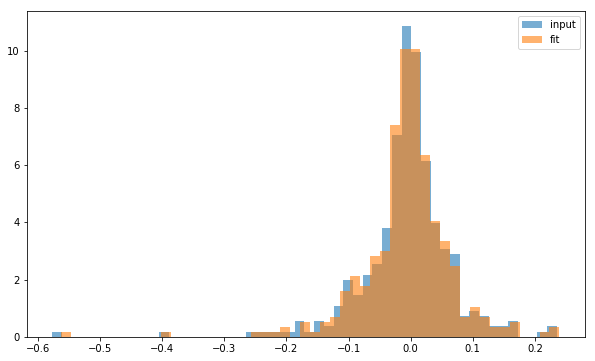

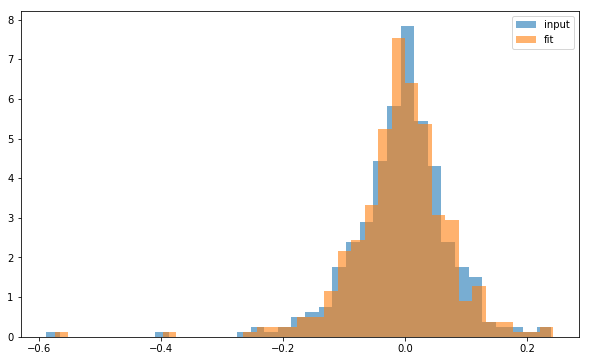

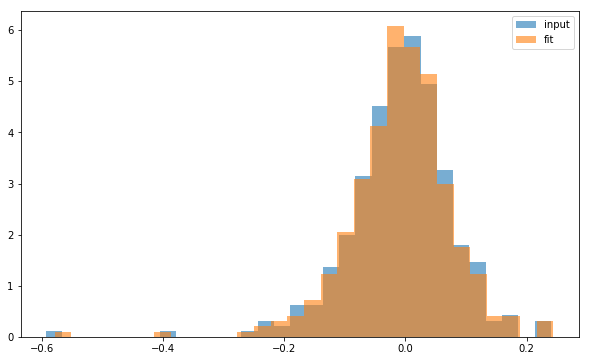

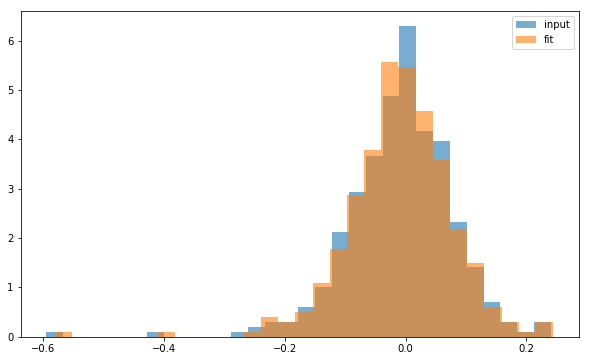

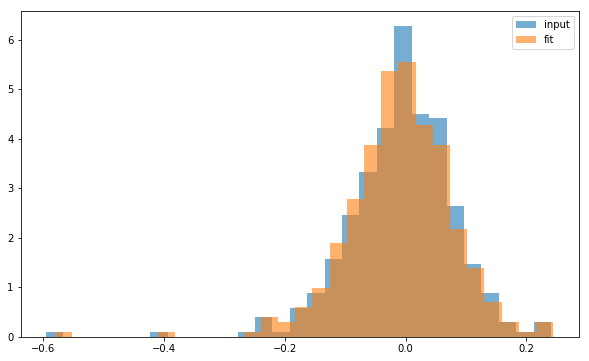

In [43]:
#histograms of the errors
for i in range(len(freqs)):
    figure(figsize=(10,6))
    hist((data[i][30:]-input_model[i][30:])/data[i][30:], density=True, alpha=0.6, label='input', bins='auto');
    hist((data[i][30:]-fit[i][30:])/data[i][30:], density=True, alpha=0.6, label='fit',bins='auto');
    legend();

# priors and probs

In [44]:
#define some weak priors, we can play with the effect of priors later
def log_prior(params):
    A_s, alpha_s, beta_s, A_d, alpha_d, beta_s, r = params
    if 0 <= A_s and 0 <= A_d  and 0 <= r:
        return 0.0
    return -np.inf

In [45]:
def log_prob(params, ells, freqs, cosmic_var, data):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp - chi2_cmb(params, ells, freqs, cosmic_var, data)

In [64]:
#for running until the chain converges or up to a maximum number of steps. Based on the emcee example.
pos = soln.x + 1e-8*np.random.randn(100, 7) #32 walkers in 7 parameter dimensions. Have to start 1e-8 because amps are so small
nwalkers, ndim = pos.shape
# nsteps = 100000

max_n = 100000

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=(ells, freqs, input_cosmic_var, data))

# We'll track how the average autocorrelation time estimate changes
index = 0
autocorr = np.empty(max_n)

# This will be useful to testing convergence
old_tau = np.inf

# Now we'll sample for up to max_n steps
for sample in sampler.sample(pos, iterations=max_n, progress='notebook'):
    # Only check convergence every 100 steps
    if sampler.iteration % 100:
        continue

    # Compute the autocorrelation time so far
    # Using tol=0 means that we'll always get an estimate even
    # if it isn't trustworthy
    tau = sampler.get_autocorr_time(tol=0)
    autocorr[index] = np.mean(tau)
    index += 1

    # Check convergence: If the chain is longer than 100 times the estimated autocorrelation time and if this 
    # estimate changed by less than 1%, we’ll consider things converged.

    converged = np.all(tau * 100 < sampler.iteration)
    converged &= np.all(np.abs(old_tau - tau) / tau < 0.01)
    if converged:
        break
    old_tau = tau

In [65]:
# pos = soln.x + 1e-8*np.random.randn(32, 7) #32 walkers in 7 parameter dimensions
# nwalkers, ndim = pos.shape
# nsteps = 100000
# sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=(ells, freqs, cosmic_var, data))
# start=time.time()
# sampler.run_mcmc(pos, nsteps, progress='notebook');
# end = time.time()
# serial_time = end - start
# print("Took {0:.1f} seconds".format(serial_time))

In [66]:
sampler.get_autocorr_time()

array([73.14483234, 69.41975228, 73.89000601, 72.90340324, 70.13438602,
       71.62097273, 70.18669497])

In [67]:
tau = sampler.get_autocorr_time()
burnin = int(2*np.max(tau))
thin = int(0.5*np.min(tau))
samples = sampler.get_chain()
flat_samples = sampler.get_chain(discard=burnin, flat=True, thin=thin)
log_prob_samples = sampler.get_log_prob(discard=burnin, flat=True, thin=thin)
log_prior_samples = sampler.get_blobs(discard=burnin, flat=True, thin=thin)

In [68]:
print("burn-in: {0}".format(burnin))
print("thin: {0}".format(thin))
print("chain shape: {0}".format(samples.shape))
print("flat chain shape: {0}".format(flat_samples.shape))

burn-in: 147
thin: 34
chain shape: (7400, 100, 7)
flat chain shape: (21300, 7)


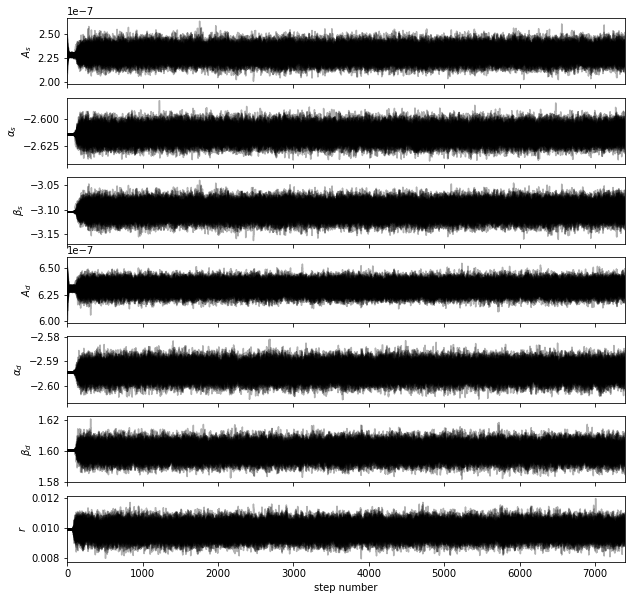

In [69]:
fig, axes = plt.subplots(7, figsize=(10, 10), sharex=True)
labels = [r"$A_s$", r"$\alpha_s$", r"$\beta_s$", r"$A_d$", r"$\alpha_d$", r"$\beta_d$", r"$r$"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:,:, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
  ###  ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

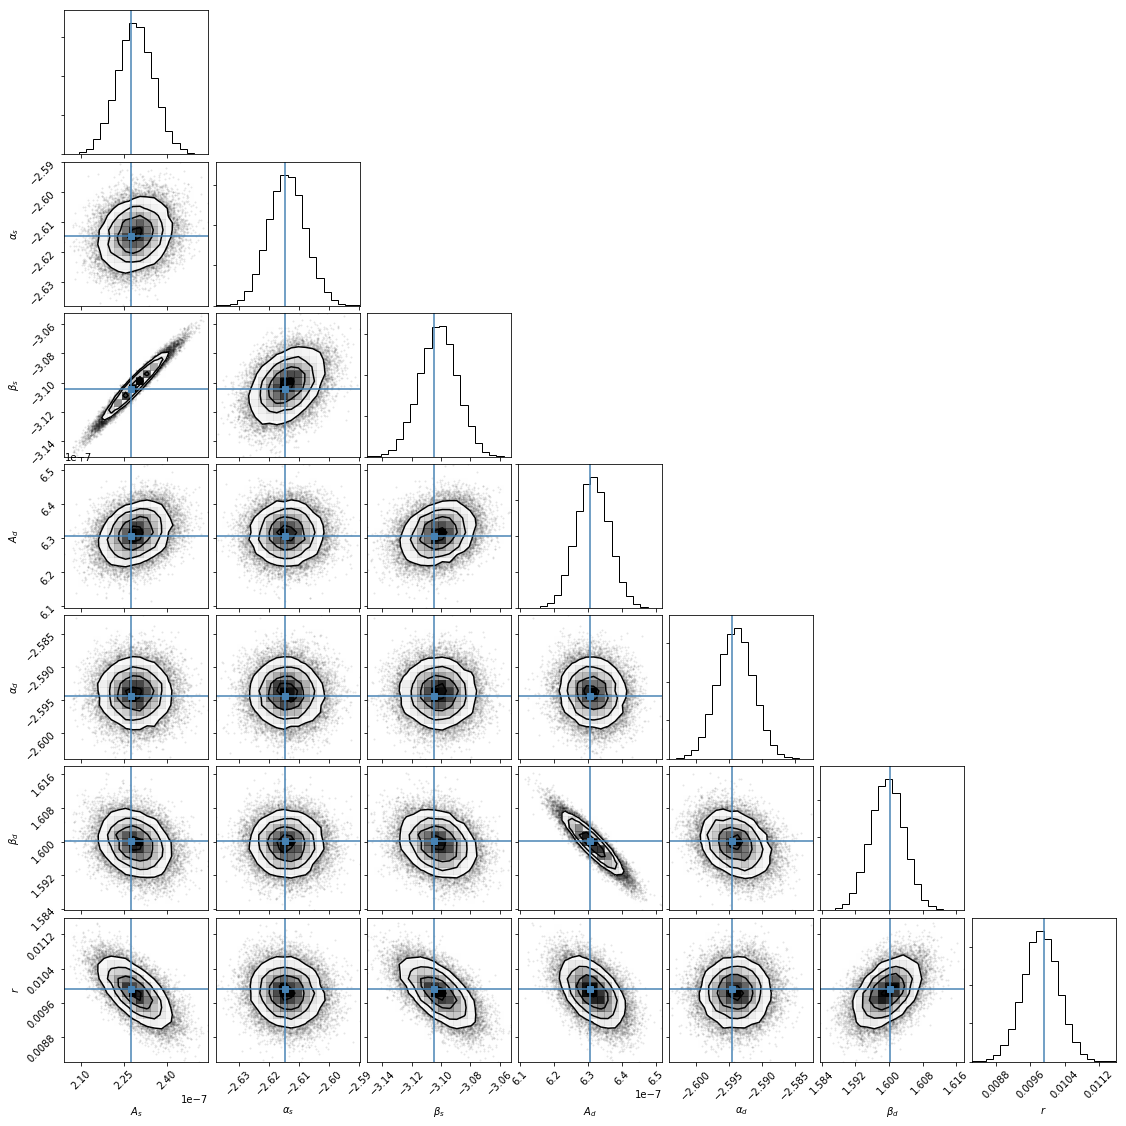

In [71]:
fig = corner.corner(flat_samples, labels=labels, truths=soln.x);
savefig('../../figures/0x0_mcmc.pdf', format='pdf', dpi=300)

# Do the same anaylsis but with SO frequencies

## maximize the function to find the starting point for the mcmc

In [72]:
input_model_SO = ff.auto0x0_fg(ells, freqs_SO, params_fg) + cmb(ells, 0.01)
input_cosmic_var_SO = cosmic_var(input_model_SO)

In [73]:
data_SO = ff.const_ps_data_fg(ells, freqs_SO, params_fg) + cmb(ells, 0.01)

In [78]:
soln_SO = minimize(chi2_cmb, initial_cmb, args=(ells, freqs_SO, input_cosmic_var_SO, data_SO), method='Powell')
print(soln)

   direc: array([[ 1.20966466e-08, -7.47143766e-03,  2.48998523e-02,
         7.39300107e-09,  8.41865504e-03, -1.17694261e-02,
        -5.00069927e-04],
       [ 1.79070930e-08, -1.55952167e-02,  3.22429108e-02,
         5.31245594e-09, -4.78815727e-03, -6.36990824e-04,
        -8.50374814e-04],
       [ 1.44141651e-08,  2.75054874e-02,  4.41596779e-02,
         4.36637342e-08, -1.12460128e-02, -3.14076239e-02,
        -1.97620654e-03],
       [-1.56884163e-08, -7.81739472e-02, -1.00815496e-01,
         9.40485709e-09,  1.32601043e-02, -1.94435507e-02,
         2.17410827e-04],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00],
       [ 2.87744934e-09,  2.23611935e-03,  5.90414056e-03,
        -5.94699692e-10, -9.62114180e-04,  1.05018745e-03,
        

In [79]:
#for running until the chain converges or up to a maximum number of steps. Based on the emcee example.
pos_SO = soln_SO.x + 1e-8*np.random.randn(100, 7) #32 walkers in 7 parameter dimensions. Have to start 1e-8 because amps are so small
nwalkers_SO, ndim_SO = pos_SO.shape

max_n = 100000

sampler_SO = emcee.EnsembleSampler(nwalkers_SO, ndim_SO, log_prob, args=(ells, freqs_SO, input_cosmic_var_SO, data_SO))

# We'll track how the average autocorrelation time estimate changes
index = 0
autocorr = np.empty(max_n)

# This will be useful to testing convergence
old_tau = np.inf

# Now we'll sample for up to max_n steps
for sample in sampler_SO.sample(pos_SO, iterations=max_n, progress='notebook'):
    # Only check convergence every 100 steps
    if sampler_SO.iteration % 100:
        continue

    # Compute the autocorrelation time so far
    # Using tol=0 means that we'll always get an estimate even
    # if it isn't trustworthy
    tau = sampler_SO.get_autocorr_time(tol=0)
    autocorr[index] = np.mean(tau)
    index += 1

    # Check convergence: If the chain is longer than 100 times the estimated autocorrelation time and if this 
    # estimate changed by less than 1%, we’ll consider things converged.

    converged = np.all(tau * 100 < sampler_SO.iteration)
    converged &= np.all(np.abs(old_tau - tau) / tau < 0.01)
    if converged:
        break
    old_tau = tau

In [80]:
sampler_SO.get_autocorr_time()

array([72.63574809, 70.56070827, 72.88583507, 75.76073759, 73.59196019,
       71.55790675, 74.32781088])

In [81]:
tau_SO = sampler_SO.get_autocorr_time()
burnin_SO = int(2*np.max(tau_SO))
thin_SO = int(0.5*np.min(tau_SO))
samples_SO = sampler_SO.get_chain()
flat_samples_SO = sampler_SO.get_chain(discard=burnin_SO, flat=True, thin=thin_SO)


In [82]:
print("burn-in: {0}".format(burnin))
print("thin: {0}".format(thin))
print("chain shape: {0}".format(samples.shape))
print("flat chain shape: {0}".format(flat_samples.shape))

burn-in: 147
thin: 34
chain shape: (7400, 100, 7)
flat chain shape: (21300, 7)


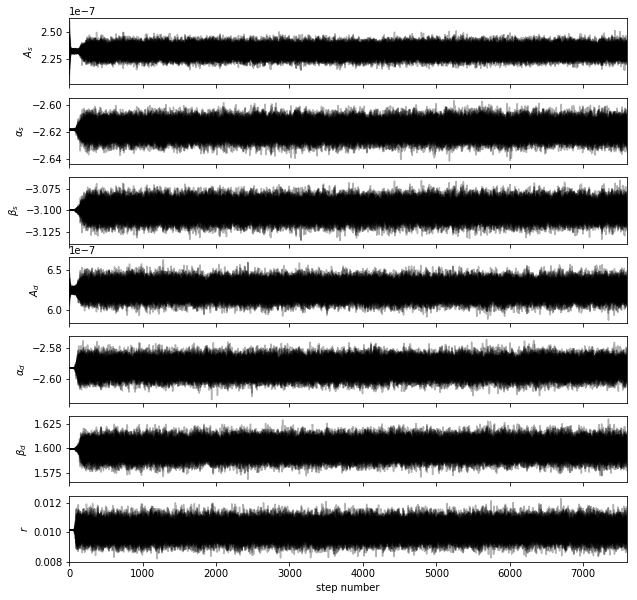

In [83]:
fig, axes = plt.subplots(7, figsize=(10, 10), sharex=True)
labels = [r"$A_s$", r"$\alpha_s$", r"$\beta_s$", r"$A_d$", r"$\alpha_d$", r"$\beta_d$", r"$r$"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples_SO[:,:, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples_SO))
    ax.set_ylabel(labels[i])
  ###  ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

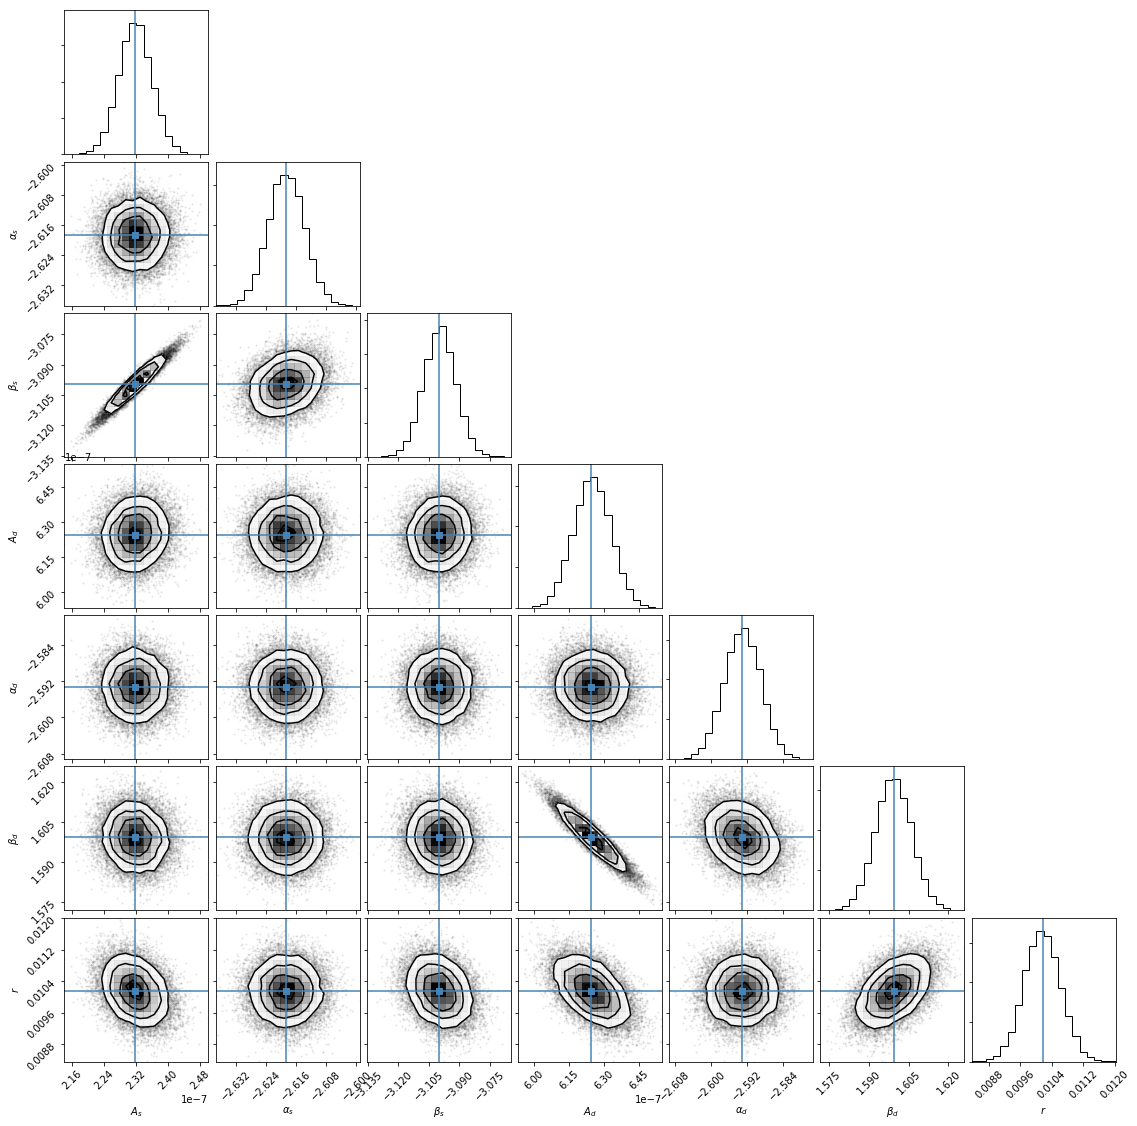

In [84]:
fig_SO = corner.corner(flat_samples_SO, labels=labels, truths=soln_SO.x);
# savefig('../../figures/0x0_mcmc_SO.pdf', format='pdf', dpi=300)

# so it looks like using the SO frequencies still works